In [ ]:
!pip install rouge
!pip install bert-score
!pip install sacrebleu
!pip install -U deep-translator

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import requests, json, os, zipfile, random
import warnings
warnings.filterwarnings("ignore")

from collections import Counter
from bs4 import BeautifulSoup
from IPython.display import clear_output, HTML, display_html
from tqdm import tqdm
import string

import nltk, re, subprocess
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import GradScaler

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, f1_score, recall_score, average_precision_score

from transformers import BertForSequenceClassification, BertModel, BertTokenizer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
from transformers import T5Tokenizer, T5ForConditionalGeneration, T5Config

from rouge import Rouge
from nltk.translate.meteor_score import single_meteor_score
from nltk.translate import meteor_score
from bert_score import score
import sacrebleu

from deep_translator import GoogleTranslator

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
PATH_TRAIN = '/content/train.tsv'
PATH_TEST = '/content/test.tsv'

data_train = pd.read_csv(PATH_TRAIN, sep='\t')
data_test = pd.read_csv(PATH_TEST, sep='\t')

### **Dataset**

In [30]:
def dynamic_padding_collate(batch, tokenizer, max_length_x=400, max_length_y=2):
    inputs = tokenizer([x for x in batch[0]], padding='longest', truncation=True, return_tensors='pt', max_length=max_length_x)
    outputs = tokenizer([x for x in batch[1]], padding='longest', truncation=True, return_tensors='pt', max_length=max_length_y)
    outputs[outputs == tokenizer.pad_token_id] = -100
    return {'input_ids': inputs['input_ids'],
            'attention_mask': inputs['attention_mask'],
            'labels': outputs['input_ids']}


class T5Dataset(Dataset):
    def __init__(self, data):
        self.questions = []
        self.answers = []
        self.preprocess(data)

    def preprocess(self, data, x=[], y=[]):
        for question in tqdm(data['question'].unique()):
            selected = data[data['question'] == question]
            question_quizz, answer_quizz = question + ' options:', ''
            for answer, correct, letter in zip(selected['answerEntity'], selected['correct'], string.ascii_uppercase):
                if correct: answer_quizz += f' {letter})'
                question_quizz += f' {letter}) {answer}.'
            self.questions.append(question_quizz)
            self.answers.append(answer_quizz[1:])

    def __len__(self):
        return len(self.questions)

    def __getitem__(self, idx):
        return self.questions[idx], self.answers[idx]

In [31]:
train_questions, test_questions = train_test_split(data_train['question'].unique(), test_size=0.1, random_state=42)

In [32]:
train = data_train[data_train['question'].isin(train_questions)]
test = data_train[data_train['question'].isin(test_questions)]

In [33]:
train_dataset = T5Dataset(train)
test_dataset = T5Dataset(test)

100%|██████████| 354/354 [00:00<00:00, 721.74it/s]


In [34]:
BATCH_SIZE = 32

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)

In [35]:
MAX_LENGTH_X = 400
MAX_LENGTH_y = 30

### **Metrics Computation**

In [36]:
def plot_train_process(epoch, losses, metrics, metric_labels=['SacreBLEU', 'ROUGEL', 'METEOR', 'BERTScore']):
    clear_output(True)
    epochs = [i for i in range(1, epoch + 1)]
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].plot(epochs, losses[:, 0], label='train loss', marker='o')
    axes[0].plot(epochs, losses[:, 1], label='test loss', marker='o')
    axes[1].plot(epochs, metrics[:, 0], marker='o', label=metric_labels[0])
    for idx in range(1, len(metrics[0])):
        axes[2].plot(epochs, metrics[:, idx], marker='o', label=metric_labels[idx])
    for i, title in enumerate(['Loss', 'BLEU metric [0, 100]', 'Other Metrics [0, 1]']):
        axes[i].set_title(title, fontweight='bold')
        axes[i].set_xlabel('epoch, N')
        axes[i].set_ylabel('metrics')
        axes[i].legend(loc='center right')
        axes[i].xaxis.set_major_locator(plt.MaxNLocator(integer=True))
    plt.show()


def compute_metrics(trues, preds):
    bleu = sacrebleu.corpus_bleu(preds, [trues]).score
    rouge = Rouge(metrics=["rouge-l"])
    rougel = rouge.get_scores(preds, trues, avg=True)['rouge-l']['f']
    meteor = [meteor_score.single_meteor_score(word_tokenize(ref), word_tokenize(hyp)) for ref, hyp in zip(trues, preds)]
    avg_meteor = sum(meteor) / len(meteor)
    P, R, F1 = score(preds, trues, lang='en', model_type='bert-base-uncased', num_layers=9)
    return bleu, rougel, avg_meteor, F1.mean().item()

### **Training T5 Model**

To accelerate the code, *gradient clipping*, *dynamic padding*, and calculation in *lower precision (AMP)* with gradient scaling were used.

In [57]:
def train_model(model, train_loader, optimizer, scaler, tokenizer):
    model.train()
    epoch_loss = 0
    for batch in tqdm(train_loader):
        batch = dynamic_padding_collate(batch, tokenizer, max_length_x=MAX_LENGTH_X, max_length_y=MAX_LENGTH_y)
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast(enabled=True):
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels, use_cache=False)
            loss = outputs.loss
        assert not loss.isnan(), "Loss is NaN. Terminating training."
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        scaler.step(optimizer)
        scaler.update()
        epoch_loss += loss.item()
    return epoch_loss / len(train_loader)


@torch.no_grad()
def test_model(model, test_loader, tokenizer):
    model.eval()
    epoch_loss = 0
    true_labels, pred_labels = [], []
    for batch in tqdm(test_loader):
        batch = dynamic_padding_collate(batch, tokenizer, max_length_x=MAX_LENGTH_X, max_length_y=MAX_LENGTH_y)
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        with torch.cuda.amp.autocast(enabled=True):
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels, use_cache=False)
        loss = outputs.loss
        epoch_loss += loss.item()
        true_labels.extend(tokenizer.batch_decode(labels, skip_special_tokens=True))
        pred_labels.extend(tokenizer.batch_decode(outputs.logits.argmax(-1), skip_special_tokens=True))
    return epoch_loss / len(test_loader), true_labels, pred_labels

In [83]:
tokenizer = T5Tokenizer.from_pretrained("google-t5/t5-base")

config = T5Config.from_pretrained("google-t5/t5-base")
config.gradient_checkpointing = True

T5_model = T5ForConditionalGeneration(config).to(device)
T5_model.config.gradient_checkpointing = True

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [84]:
N_EPOCHS = 1
LEARNING_RATE = 1e-5

optimizer = optim.SGD(T5_model.parameters(), lr=LEARNING_RATE)
scaler = GradScaler(init_scale=8192, growth_interval=1000)

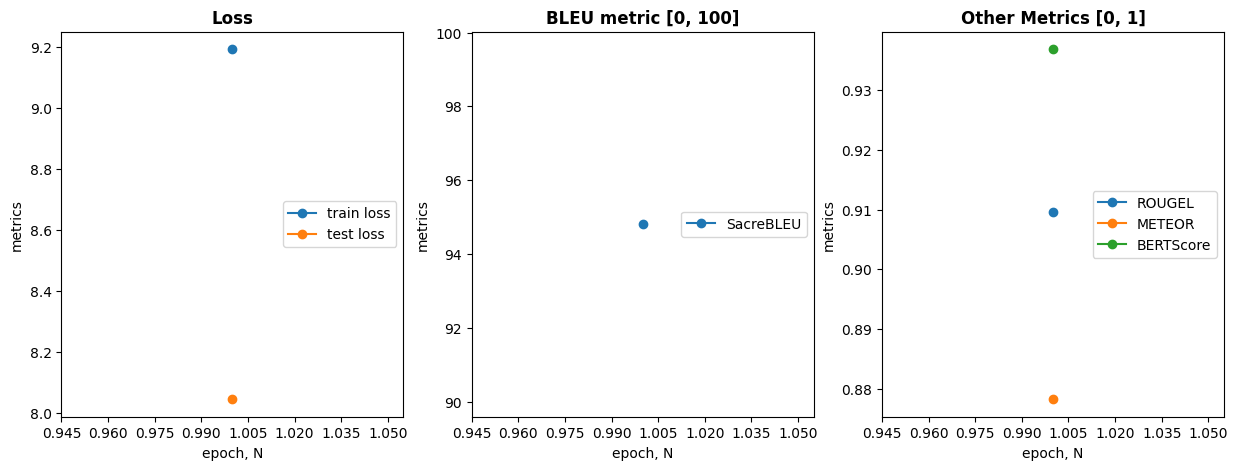

Epoch: 1, Train Loss: 9.1921, Test Loss: 8.0446, BLEU=94.81, Rouge=0.91, METEOR=0.88, F1=0.94


In [85]:
metrics, losses = [], []

for epoch in range(1, N_EPOCHS + 1):
    train_loss = train_model(T5_model, train_loader, optimizer, scaler, tokenizer)
    test_loss, trues, preds = test_model(T5_model, test_loader, tokenizer)
    bleu, rougel, meteor, f1 = compute_metrics(trues, preds)
    metrics.append([bleu, rougel, meteor, f1])
    losses.append([train_loss, test_loss])
    plot_train_process(epoch, np.array(losses), np.array(metrics))
    print(f'Epoch: {epoch}, Train Loss: {np.array(losses)[:, 0][epoch-1]:.4f}, '
          f'Test Loss: {np.array(losses)[:, 1][epoch-1]:.4f}, '
          f'BLEU={bleu:.2f}, Rouge={rougel:.2f}, METEOR={meteor:.2f}, F1={f1:.2f}')

## Not Successful attempts
The most unlucky think was that I used AdamW optimizator!!!!!!!

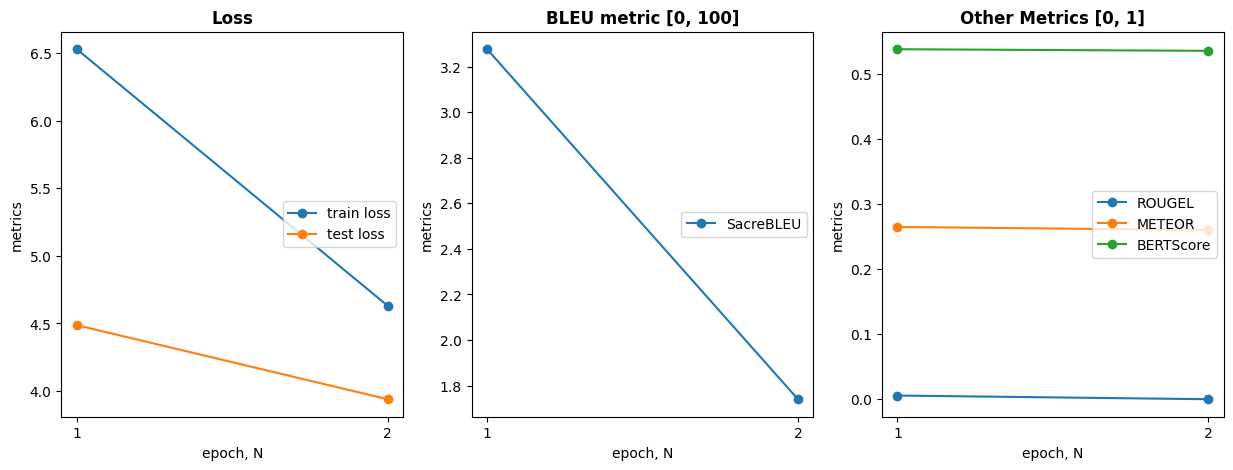

Epoch: 2, Train Loss: 4.6305, Test Loss: 3.9386, BLEU=1.74, Rouge=0.00, METEOR=0.26, F1=0.54


 28%|██▊       | 28/100 [00:16<00:41,  1.74it/s]


KeyboardInterrupt: 

In [61]:
# Learning rate = 1e-4

metrics, losses = [], []

for epoch in range(1, N_EPOCHS + 1):
    train_loss = train_model(T5_model, train_loader, optimizer, scaler, tokenizer)
    test_loss, trues, preds = test_model(T5_model, test_loader, tokenizer)
    bleu, rougel, meteor, f1 = compute_metrics(trues, preds)
    metrics.append([bleu, rougel, meteor, f1])
    losses.append([train_loss, test_loss])
    plot_train_process(epoch, np.array(losses), np.array(metrics))
    print(f'Epoch: {epoch}, Train Loss: {np.array(losses)[:, 0][epoch-1]:.4f}, '
          f'Test Loss: {np.array(losses)[:, 1][epoch-1]:.4f}, '
          f'BLEU={bleu:.2f}, Rouge={rougel:.2f}, METEOR={meteor:.2f}, F1={f1:.2f}')